In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
from skimage.data import shepp_logan_phantom
from tqdm.notebook import tqdm

## Q1

### Part 0: load and add noise

In [3]:
def add_salt_and_pepper_noise(img, percent=0.01):
    rows, cols = img.shape

    num_pixels = rows * cols
    num_noise_pixels = int(num_pixels * percent)

    noisy_img = img.copy()

    for i in range(num_noise_pixels):
        x = np.random.randint(0, rows)
        y = np.random.randint(0, cols)
        value = np.random.randint(0, 2)
        if value == 0:
            noisy_img[x, y] = 0
        else:
            noisy_img[x, y] = 255
    
    return noisy_img

def add_gaussian_noise(img, mu=0.5, var=0.1):
    gaussian_noise = np.zeros(img.shape, np.uint8)
    gaussian_noise = cv2.randn(gaussian_noise, mu, np.sqrt(var))
    noisy_img = cv2.add(img, gaussian_noise)
    return noisy_img

In [4]:
img1 = cv2.imread('Image1.png')
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)

img2 = cv2.imread('Image2.png')
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

sp_noisy_img1 = add_salt_and_pepper_noise(img1)
gaussian_noisy_img1 = add_gaussian_noise(img1)

sp_noisy_img2 = add_salt_and_pepper_noise(img2)
gaussian_noisy_img2 = add_gaussian_noise(img2)

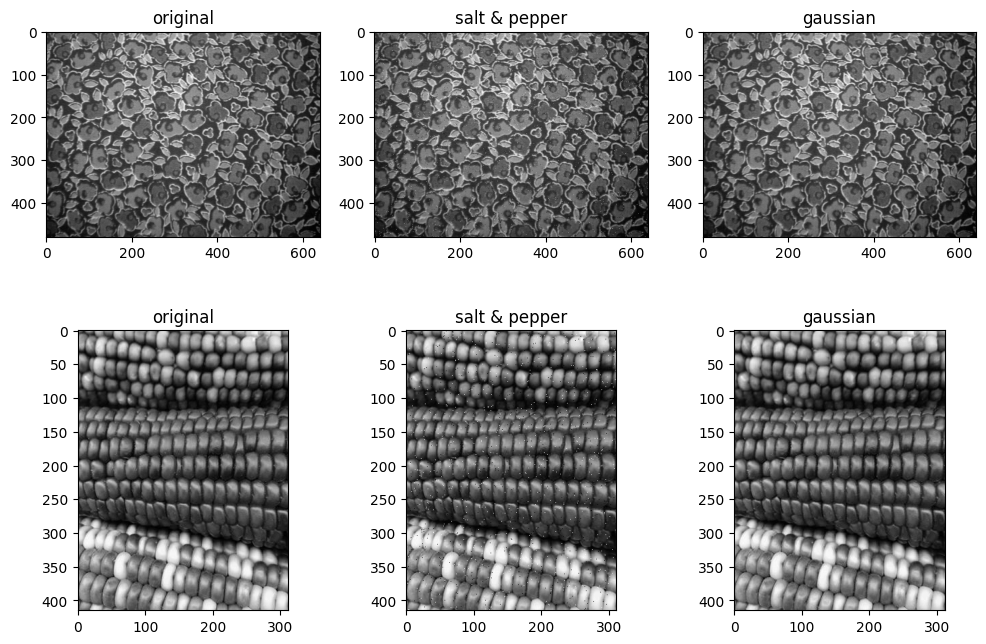

In [ ]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 3, 1)
plt.imshow(img1, 'gray')
plt.title('original')

plt.subplot(2, 3, 2)
plt.imshow(sp_noisy_img1, 'gray')
plt.title('salt & pepper')

plt.subplot(2, 3, 3)
plt.imshow(gaussian_noisy_img1, 'gray')
plt.title('gaussian')

plt.subplot(2, 3, 4)
plt.imshow(img2, 'gray')
plt.title('original')

plt.subplot(2, 3, 5)
plt.imshow(sp_noisy_img2, 'gray')
plt.title('salt & pepper')

plt.subplot(2, 3, 6)
plt.imshow(gaussian_noisy_img2, 'gray')
plt.title('gaussian')

plt.show()

### Part 1: denoise with NLM and calculate PSNR

In [5]:
def filter_img(img, kernel):
    norm = np.sum(kernel)
    kernel = kernel / norm
    filtered_img = cv2.filter2D(src=img, ddepth=-1, kernel=kernel)
    return filtered_img


def non_local_means(image, window_size, patch_size, sigma):
    # window size (W) is the size of the window used for searching for similar patches.
    # path_size (W_sim) is the size of the local patch used for computing weights
    
    padded_image = np.pad(image, window_size, mode='symmetric')
    filtered_image = np.zeros_like(image)

    for i in tqdm(range(window_size, padded_image.shape[0] - window_size)):
        for j in range(window_size, padded_image.shape[1] - window_size):
            patch = padded_image[i-patch_size:i+patch_size+1, j-patch_size:j+patch_size+1] / 255

            total_weight = 0.0
            filtered_value = 0.0

            for k in range(i-window_size+patch_size, i+window_size-patch_size+1):
                for l in range(j-window_size+patch_size, j+window_size-patch_size+1):
                    window = padded_image[k-patch_size:k+patch_size+1, l-patch_size:l+patch_size+1] / 255

                    distance = np.sum((patch.astype(np.float32) - window.astype(np.float32)) ** 2)
                    weight = np.exp(-distance / sigma)

                    filtered_value += weight * padded_image[k, l]
                    total_weight += weight

            filtered_image[i-window_size, j-window_size] = filtered_value / total_weight

    return filtered_image


def PSNR(img1, img2, max_pixel_value=255):
    mse = np.mean((img1.astype(np.float32) - img2.astype(np.float32)) ** 2)
    psnr = 10 * np.log10((max_pixel_value ** 2) / mse)
    return psnr


def nlm_denoise_and_calc_psnr(img, sp_noisy_img, gaussian_noisy_img, window_size=3, patch_size=3):

    sigmas = np.arange(0.1, 0.5+0.1, 0.1)
    PSNR_NLM_sp = []
    PSNR_NLM_gaussian = []

    plt.figure(figsize=(15, 6))
    for i, sigma in enumerate(tqdm(sigmas)):
        filtered_image = non_local_means(sp_noisy_img, window_size, patch_size, sigma)
        psnr = PSNR(img, filtered_image, max_pixel_value=255)
        PSNR_NLM_sp.append(psnr)

        plt.subplot(2, len(sigmas), i+1)
        plt.imshow(filtered_image, 'gray')
        plt.title(f'salt & pepper, sigma={round(sigma, 1)}')

        filtered_image = non_local_means(gaussian_noisy_img, window_size, patch_size, sigma)
        psnr = PSNR(img, filtered_image, max_pixel_value=255)
        PSNR_NLM_gaussian.append(psnr)

        plt.subplot(2, len(sigmas), len(sigmas)+i+1)
        plt.imshow(filtered_image, 'gray')
        plt.title(f'gaussian, sigma={round(sigma, 1)}')
    plt.show()
    return PSNR_NLM_sp, PSNR_NLM_gaussian

#### Results for Image 1

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/480 [00:00<?, ?it/s]

  0%|          | 0/480 [00:00<?, ?it/s]

  0%|          | 0/480 [00:00<?, ?it/s]

  0%|          | 0/480 [00:00<?, ?it/s]

  0%|          | 0/480 [00:00<?, ?it/s]

  0%|          | 0/480 [00:00<?, ?it/s]

  0%|          | 0/480 [00:00<?, ?it/s]

  0%|          | 0/480 [00:00<?, ?it/s]

  0%|          | 0/480 [00:00<?, ?it/s]

  0%|          | 0/480 [00:00<?, ?it/s]

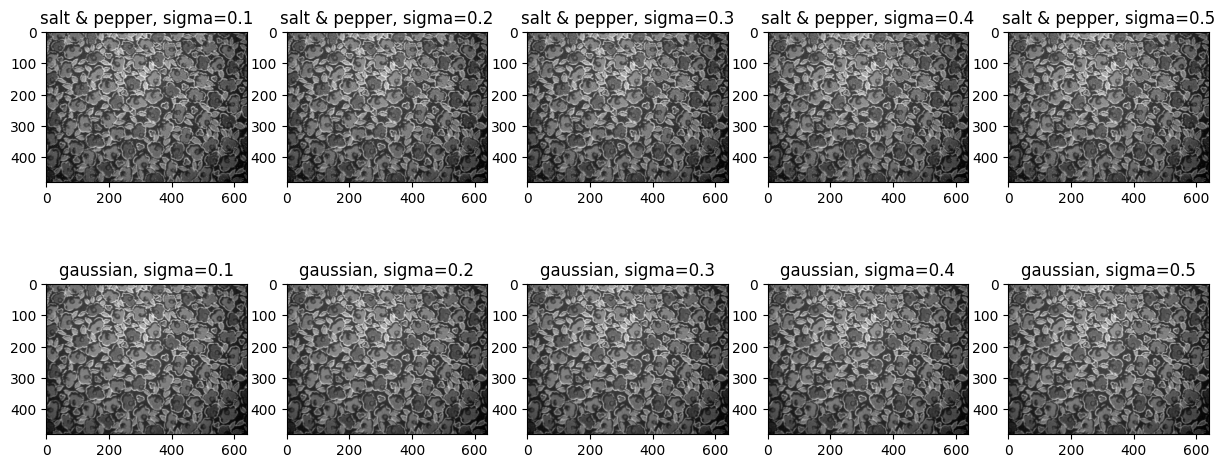

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/480 [00:00<?, ?it/s]

  0%|          | 0/480 [00:00<?, ?it/s]

  0%|          | 0/480 [00:00<?, ?it/s]

  0%|          | 0/480 [00:00<?, ?it/s]

  0%|          | 0/480 [00:00<?, ?it/s]

  0%|          | 0/480 [00:00<?, ?it/s]

  0%|          | 0/480 [00:00<?, ?it/s]

  0%|          | 0/480 [00:00<?, ?it/s]

  0%|          | 0/480 [00:00<?, ?it/s]

  0%|          | 0/480 [00:00<?, ?it/s]

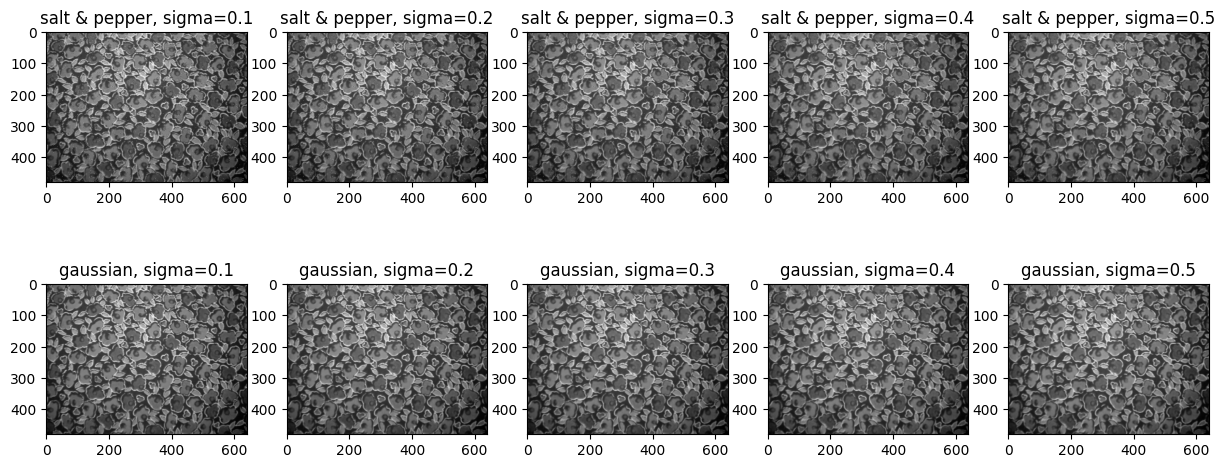

In [ ]:
PSNR_NLM_sp_img1W3, PSNR_NLM_gaussian_img1W3 = nlm_denoise_and_calc_psnr(img1, sp_noisy_img1, gaussian_noisy_img1, window_size=3, patch_size=3)

PSNR_NLM_sp_img1W5, PSNR_NLM_gaussian_img1W5 = nlm_denoise_and_calc_psnr(img1, sp_noisy_img1, gaussian_noisy_img1, window_size=5, patch_size=3)

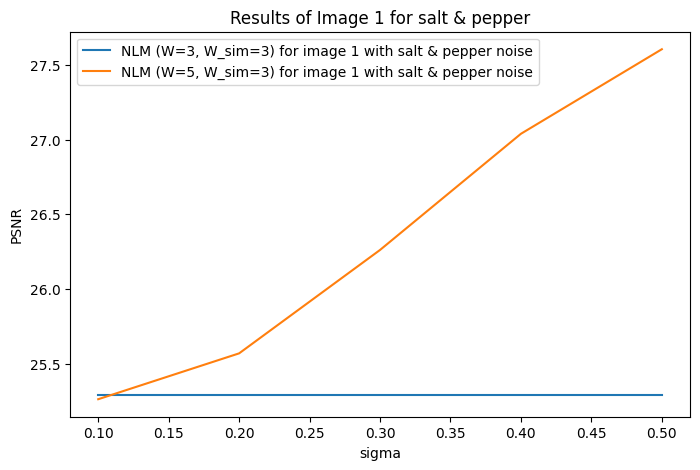

In [ ]:
sigma = np.arange(0.1, 0.6, 0.1)

plt.figure(figsize=(8, 5))
plt.plot(sigma, PSNR_NLM_sp_img1W3)
plt.plot(sigma, PSNR_NLM_sp_img1W5)
plt.title('Results of Image 1 for salt & pepper')
plt.ylabel('PSNR')
plt.xlabel('sigma')
plt.legend(['NLM (W=3, W_sim=3)', 'NLM (W=5, W_sim=3)'])

plt.show()

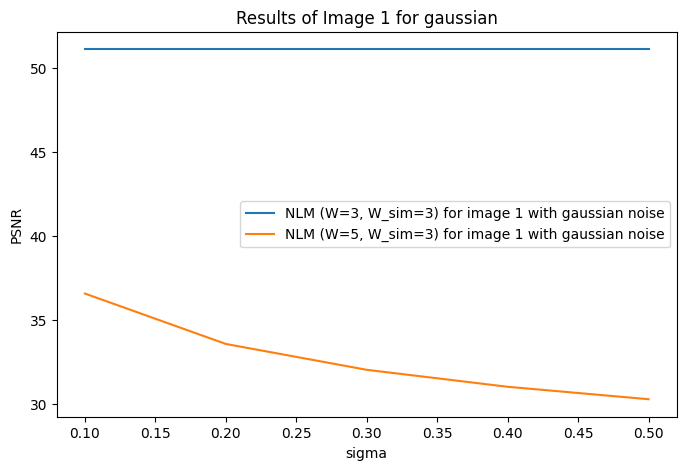

In [ ]:
sigma = np.arange(0.1, 0.6, 0.1)

plt.figure(figsize=(8, 5))
plt.plot(sigma, PSNR_NLM_gaussian_img1W3)
plt.plot(sigma, PSNR_NLM_gaussian_img1W5)
plt.title('Results of Image 1 for gaussian')
plt.ylabel('PSNR')
plt.xlabel('sigma')
plt.legend(['NLM (W=3, W_sim=3)', 'NLM (W=5, W_sim=3)'])

plt.show()

**When we have window_size = patch_size, so the algorithm acts like local mean. therefore the PSNR is const over different sigma value.**

#### Results for Image 2

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/415 [00:00<?, ?it/s]

  0%|          | 0/415 [00:00<?, ?it/s]

  0%|          | 0/415 [00:00<?, ?it/s]

  0%|          | 0/415 [00:00<?, ?it/s]

  0%|          | 0/415 [00:00<?, ?it/s]

  0%|          | 0/415 [00:00<?, ?it/s]

  0%|          | 0/415 [00:00<?, ?it/s]

  0%|          | 0/415 [00:00<?, ?it/s]

  0%|          | 0/415 [00:00<?, ?it/s]

  0%|          | 0/415 [00:00<?, ?it/s]

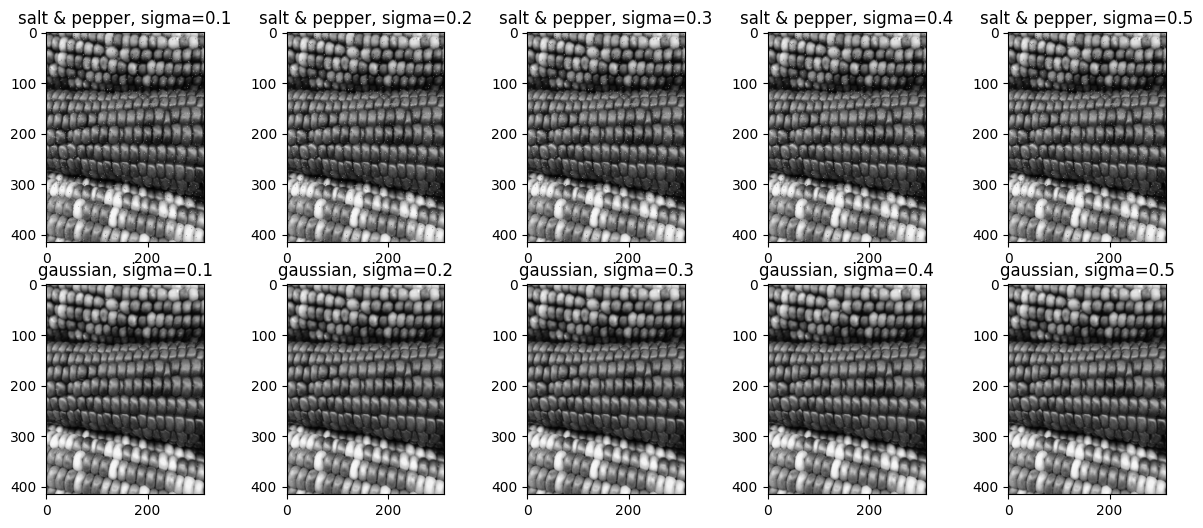

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/415 [00:00<?, ?it/s]

  0%|          | 0/415 [00:00<?, ?it/s]

  0%|          | 0/415 [00:00<?, ?it/s]

  0%|          | 0/415 [00:00<?, ?it/s]

  0%|          | 0/415 [00:00<?, ?it/s]

  0%|          | 0/415 [00:00<?, ?it/s]

  0%|          | 0/415 [00:00<?, ?it/s]

  0%|          | 0/415 [00:00<?, ?it/s]

  0%|          | 0/415 [00:00<?, ?it/s]

  0%|          | 0/415 [00:00<?, ?it/s]

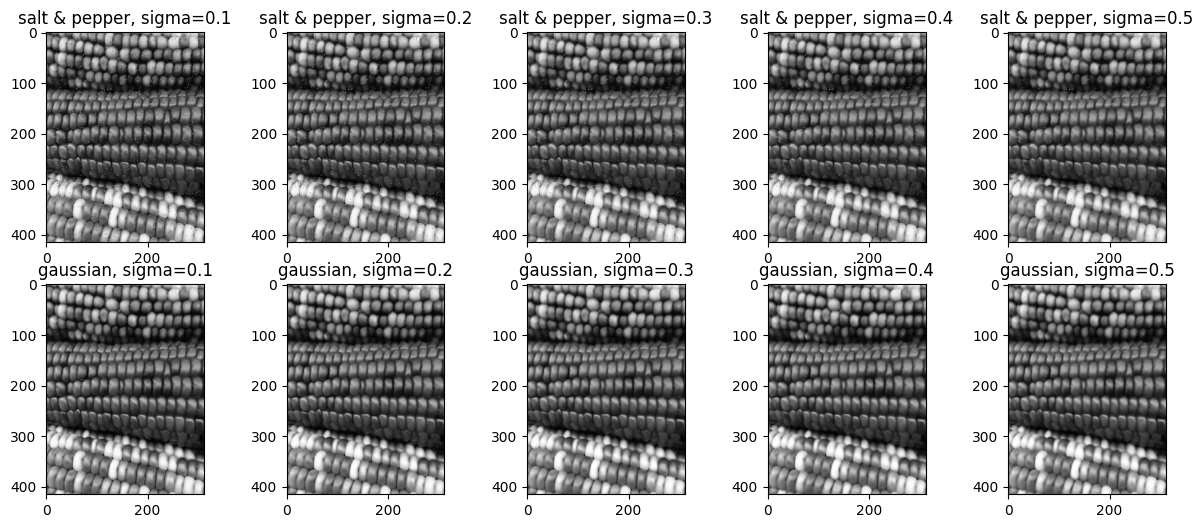

In [ ]:
PSNR_NLM_sp_img2W3, PSNR_NLM_gaussian_img2W3 = nlm_denoise_and_calc_psnr(img2, sp_noisy_img2, gaussian_noisy_img2, window_size=3, patch_size=3)

PSNR_NLM_sp_img2W5, PSNR_NLM_gaussian_img2W5 = nlm_denoise_and_calc_psnr(img2, sp_noisy_img2, gaussian_noisy_img2, window_size=5, patch_size=3)

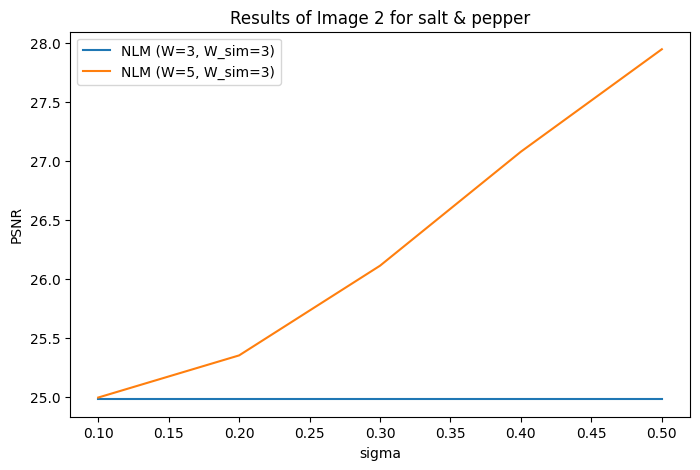

In [ ]:
sigma = np.arange(0.1, 0.6, 0.1)

plt.figure(figsize=(8, 5))
plt.plot(sigma, PSNR_NLM_sp_img2W3)
plt.plot(sigma, PSNR_NLM_sp_img2W5)
plt.title('Results of Image 2 for salt & pepper')
plt.ylabel('PSNR')
plt.xlabel('sigma')
plt.legend(['NLM (W=3, W_sim=3)', 'NLM (W=5, W_sim=3)'])

plt.show()

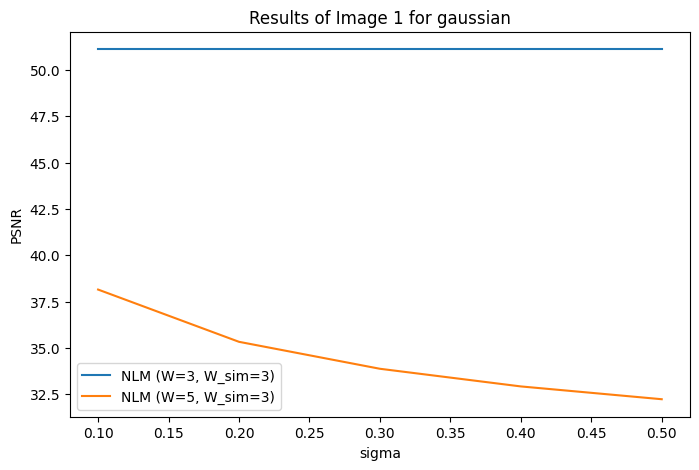

In [ ]:
sigma = np.arange(0.1, 0.6, 0.1)

plt.figure(figsize=(8, 5))
plt.plot(sigma, PSNR_NLM_gaussian_img2W3)
plt.plot(sigma, PSNR_NLM_gaussian_img2W5)
plt.title('Results of Image 1 for gaussian')
plt.ylabel('PSNR')
plt.xlabel('sigma')
plt.legend(['NLM (W=3, W_sim=3)', 'NLM (W=5, W_sim=3)'])

plt.show()

### Part 2: gaussian filter

In [7]:
def gaussian_filter(kernel_size=7, sigma=0.1):
    w = kernel_size // 2
    kernel = np.zeros((kernel_size, kernel_size))
    for i in range(kernel_size):
        for j in range(kernel_size):
            kernel[i, j] = 1 / np.sqrt(2 * np.pi * sigma ** 2) * np.exp(-((i - w) ** 2 + (j - w) ** 2) / (2 * sigma ** 2))
    return kernel

def filter_img(img, kernel):
    norm = np.sum(kernel)
    kernel = kernel / norm
    filtered_img = cv2.filter2D(src=img, ddepth=-1, kernel=kernel)
    return filtered_img

def gaussian_denoise_and_calc_psnr(img, sp_noisy_img, gaussian_noisy_img):
    sigmas = np.arange(0.1, 0.5+0.1, 0.1)
    PSNR_NLM_sp = []
    PSNR_NLM_gaussian = []

    plt.figure(figsize=(15, 6))
    for i, sigma in enumerate(tqdm(sigmas)):
        kernel = gaussian_filter(kernel_size=3, sigma=sigma)
        filtered_image = filter_img(sp_noisy_img, kernel)
        psnr = PSNR(img, filtered_image, max_pixel_value=255)
        PSNR_NLM_sp.append(psnr)

        plt.subplot(2, len(sigmas), i+1)
        plt.imshow(filtered_image, 'gray')
        plt.title(f'salt & pepper, sigma={round(sigma, 1)}')

        kernel = gaussian_filter(kernel_size=3, sigma=sigma)
        filtered_image = filter_img(gaussian_noisy_img, kernel)
        psnr = PSNR(img, filtered_image, max_pixel_value=255)
        PSNR_NLM_gaussian.append(psnr)

        plt.subplot(2, len(sigmas), len(sigmas)+i+1)
        plt.imshow(filtered_image, 'gray')
        plt.title(f'gaussian, sigma={round(sigma, 1)}')
    plt.show()
    return PSNR_NLM_sp, PSNR_NLM_gaussian

#### Results for imgae 1

  0%|          | 0/5 [00:00<?, ?it/s]

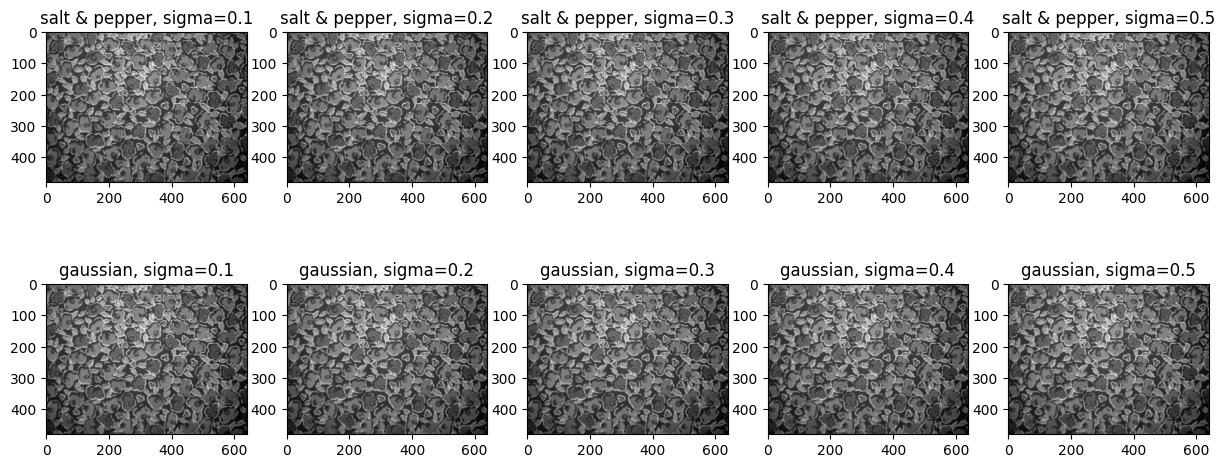

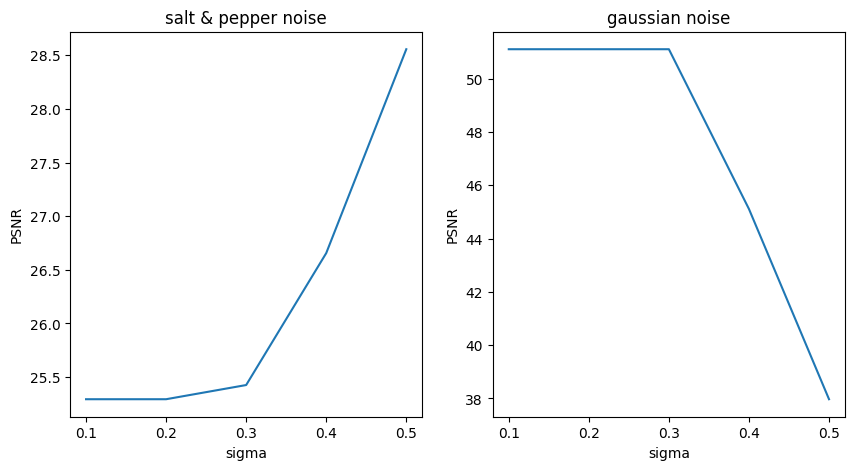

In [ ]:
PSNR_NLM_sp_img1g, PSNR_NLM_gaussian_img1g = gaussian_denoise_and_calc_psnr(img1, sp_noisy_img1, gaussian_noisy_img1)

sigma = np.arange(0.1, 0.6, 0.1)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(sigma, PSNR_NLM_sp_img1g)
plt.title('salt & pepper noise')
plt.ylabel('PSNR')
plt.xlabel('sigma')

plt.subplot(1, 2, 2)
plt.plot(sigma, PSNR_NLM_gaussian_img1g)
plt.title('gaussian noise')
plt.ylabel('PSNR')
plt.xlabel('sigma')

plt.show()

#### Results for image 2

  0%|          | 0/5 [00:00<?, ?it/s]

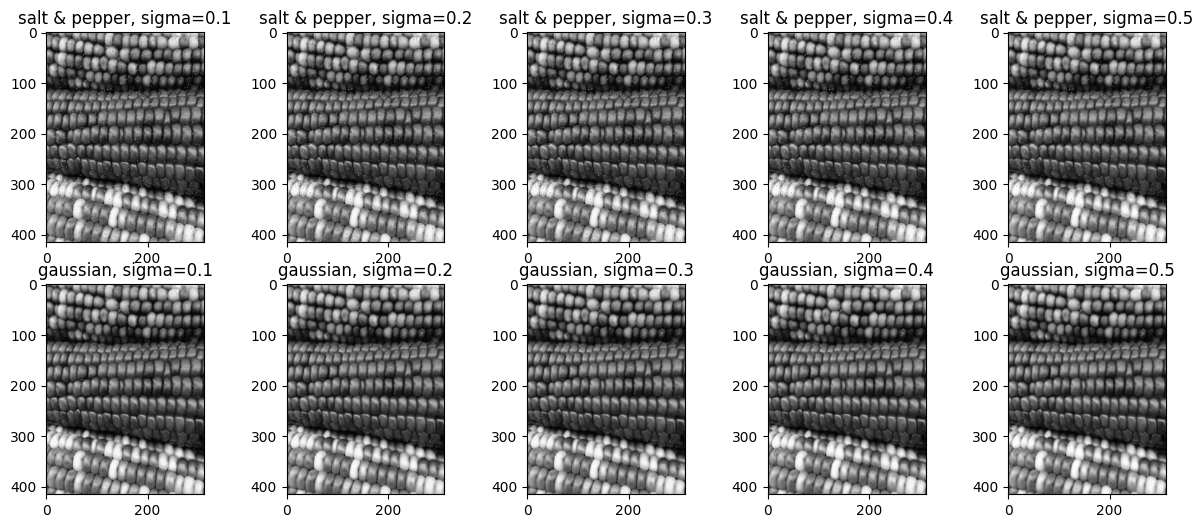

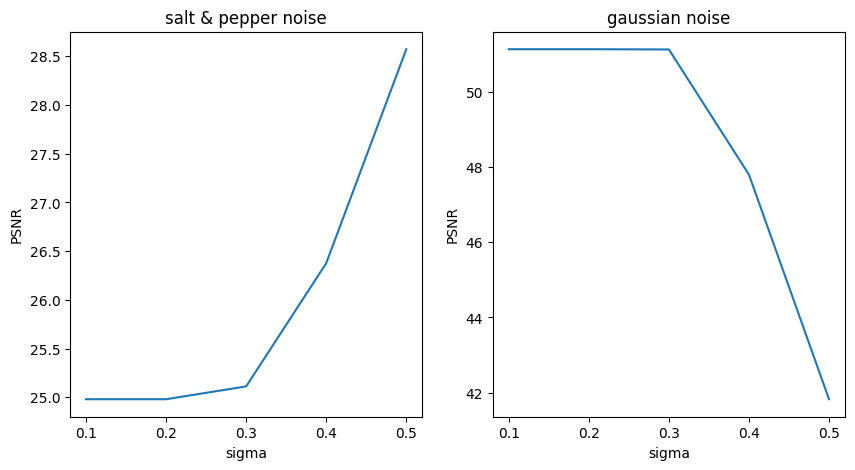

In [ ]:
PSNR_NLM_sp_img2g, PSNR_NLM_gaussian_img2g = gaussian_denoise_and_calc_psnr(img2, sp_noisy_img2, gaussian_noisy_img2)

sigma = np.arange(0.1, 0.6, 0.1)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(sigma, PSNR_NLM_sp_img2g)
plt.title('salt & pepper noise')
plt.ylabel('PSNR')
plt.xlabel('sigma')

plt.subplot(1, 2, 2)
plt.plot(sigma, PSNR_NLM_gaussian_img2g)
plt.title('gaussian noise')
plt.ylabel('PSNR')
plt.xlabel('sigma')

plt.show()

### Conclusion

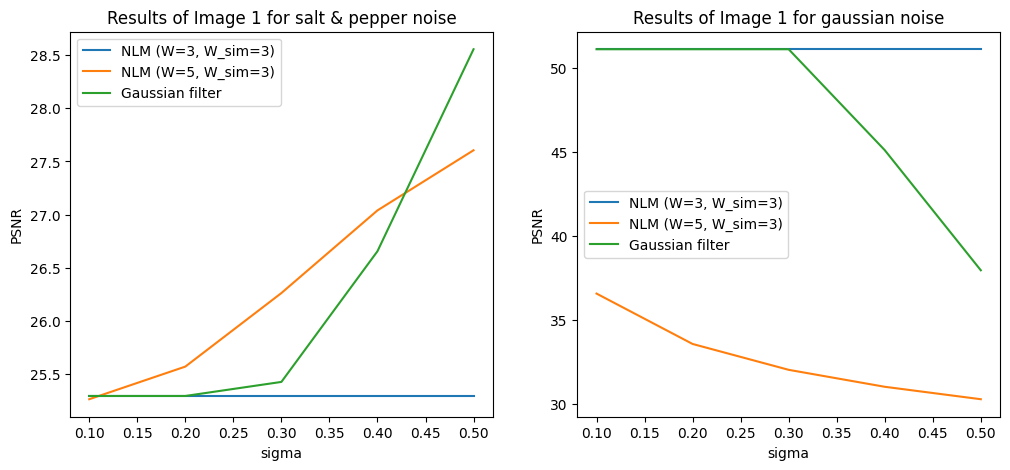

In [ ]:
sigma = np.arange(0.1, 0.6, 0.1)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(sigma, PSNR_NLM_sp_img1W3)
plt.plot(sigma, PSNR_NLM_sp_img1W5)
plt.plot(sigma, PSNR_NLM_sp_img1g)
plt.title('Results of Image 1 for salt & pepper noise')
plt.ylabel('PSNR')
plt.xlabel('sigma')
plt.legend(['NLM (W=3, W_sim=3)', 'NLM (W=5, W_sim=3)', 'Gaussian filter'])

plt.subplot(1, 2, 2)
plt.plot(sigma, PSNR_NLM_gaussian_img1W3)
plt.plot(sigma, PSNR_NLM_gaussian_img1W5)
plt.plot(sigma, PSNR_NLM_gaussian_img1g)
plt.title('Results of Image 1 for gaussian noise')
plt.ylabel('PSNR')
plt.xlabel('sigma')
plt.legend(['NLM (W=3, W_sim=3)', 'NLM (W=5, W_sim=3)', 'Gaussian filter'])

plt.show()

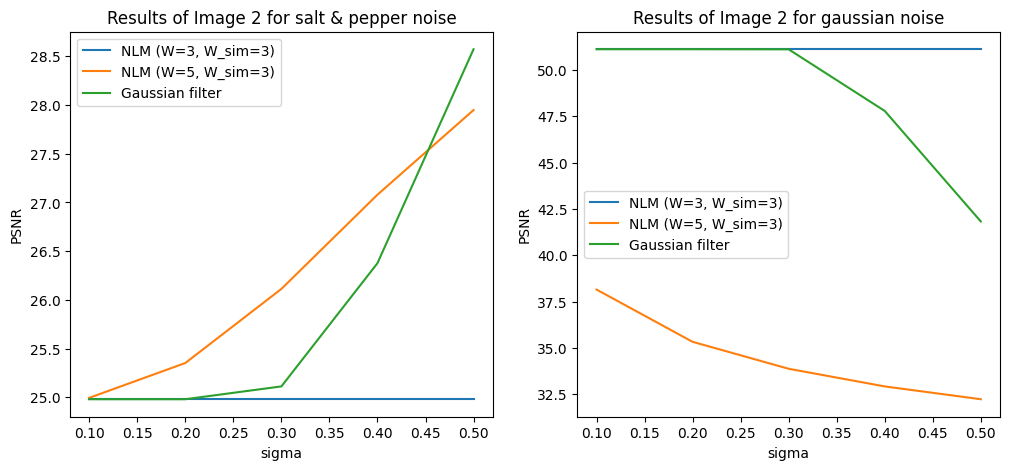

In [ ]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(sigma, PSNR_NLM_sp_img2W3)
plt.plot(sigma, PSNR_NLM_sp_img2W5)
plt.plot(sigma, PSNR_NLM_sp_img2g)
plt.title('Results of Image 2 for salt & pepper noise')
plt.ylabel('PSNR')
plt.xlabel('sigma')
plt.legend(['NLM (W=3, W_sim=3)', 'NLM (W=5, W_sim=3)', 'Gaussian filter'])


plt.subplot(1, 2, 2)
plt.plot(sigma, PSNR_NLM_gaussian_img2W3)
plt.plot(sigma, PSNR_NLM_gaussian_img2W5)
plt.plot(sigma, PSNR_NLM_gaussian_img2g)
plt.title('Results of Image 2 for gaussian noise')
plt.ylabel('PSNR')
plt.xlabel('sigma')
plt.legend(['NLM (W=3, W_sim=3)', 'NLM (W=5, W_sim=3)', 'Gaussian filter'])

plt.show()

NLM filter is a non-linear filter that uses a weighted average of pixels in a local neighborhood to reduce noise in an image. It works by comparing the similarity between two patches of pixels in an image and then averaging them based on their similarity. NLM filter supports the comparison of regions rather than pixel comparison.

On the other hand, Gaussian filter is a linear filter that uses a Gaussian function to blur an image. It works by convolving an image with a Gaussian kernel to produce a smoothed version of the original image.

In summary, NLM filter is more effective than Gaussian filter in reducing noise in an image because it takes into account the similarity between regions rather than just pixel comparison. However, it is computationally expensive compared to Gaussian filter.

In [8]:
nlm_sp_filtered_image1 = non_local_means(sp_noisy_img1, window_size=5, patch_size=3, sigma=0.5)
kernel = gaussian_filter(kernel_size=3, sigma=0.5)
gaussian_sp_filtered_image1 = filter_img(sp_noisy_img1, kernel)

nlm_gaussian_filtered_image1 = non_local_means(gaussian_noisy_img1, window_size=3, patch_size=3, sigma=0.1)
kernel = gaussian_filter(kernel_size=3, sigma=0.2)
gaussian_gaussian_filtered_image1 = filter_img(gaussian_noisy_img1, kernel)

  0%|          | 0/480 [00:00<?, ?it/s]

  0%|          | 0/480 [00:00<?, ?it/s]

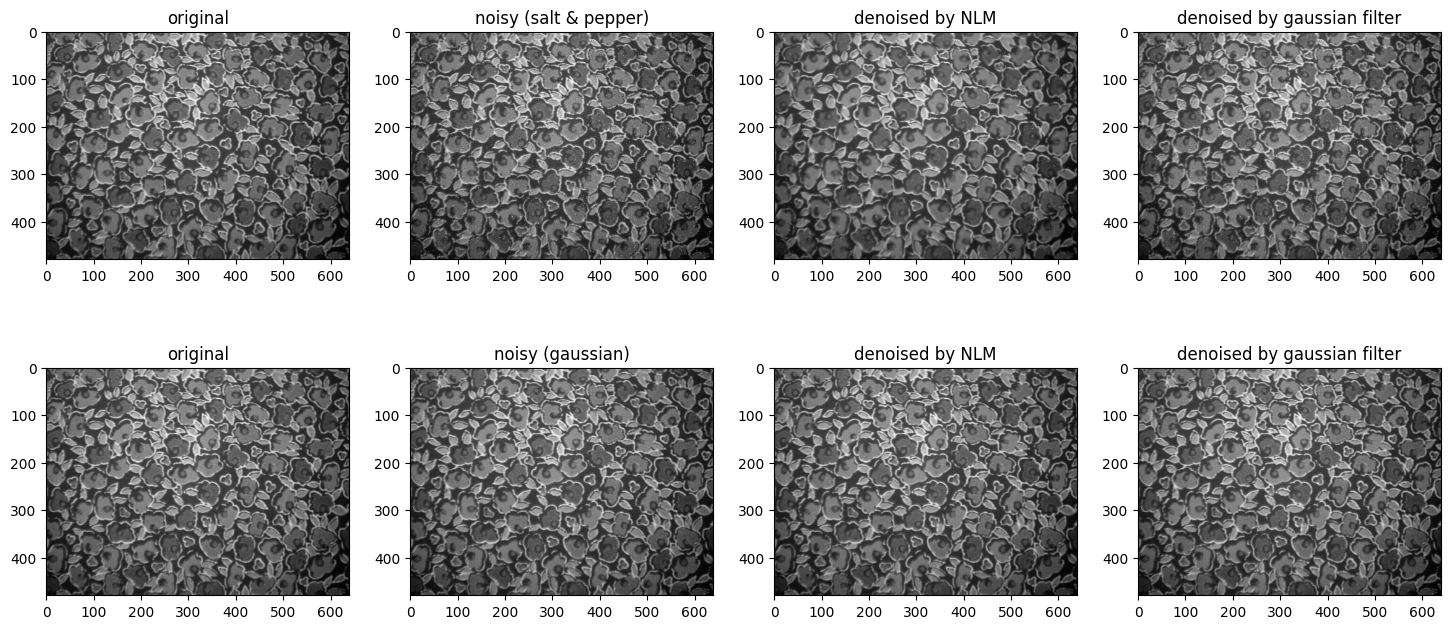

In [13]:
plt.figure(figsize=(18, 8))

plt.subplot(2, 4, 1)
plt.imshow(img1, 'gray')
plt.title('original')

plt.subplot(2, 4, 2)
plt.imshow(sp_noisy_img1, 'gray')
plt.title('noisy (salt & pepper)')

plt.subplot(2, 4, 3)
plt.imshow(nlm_sp_filtered_image1, 'gray')
plt.title('denoised by NLM')

plt.subplot(2, 4, 4)
plt.imshow(gaussian_sp_filtered_image1, 'gray')
plt.title('denoised by gaussian filter')

plt.subplot(2, 4, 5)
plt.imshow(img1, 'gray')
plt.title('original')

plt.subplot(2, 4, 6)
plt.imshow(gaussian_noisy_img1, 'gray')
plt.title('noisy (gaussian)')

plt.subplot(2, 4, 7)
plt.imshow(nlm_gaussian_filtered_image1, 'gray')
plt.title('denoised by NLM')

plt.subplot(2, 4, 8)
plt.imshow(gaussian_gaussian_filtered_image1, 'gray')
plt.title('denoised by gaussian filter')

plt.show()

In [14]:
nlm_sp_filtered_image2 = non_local_means(sp_noisy_img2, window_size=5, patch_size=3, sigma=0.5)
kernel = gaussian_filter(kernel_size=3, sigma=0.5)
gaussian_sp_filtered_image2 = filter_img(sp_noisy_img2, kernel)

nlm_gaussian_filtered_image2 = non_local_means(gaussian_noisy_img2, window_size=3, patch_size=3, sigma=0.1)
kernel = gaussian_filter(kernel_size=3, sigma=0.2)
gaussian_gaussian_filtered_image2 = filter_img(gaussian_noisy_img2, kernel)

  0%|          | 0/415 [00:00<?, ?it/s]

  0%|          | 0/415 [00:00<?, ?it/s]

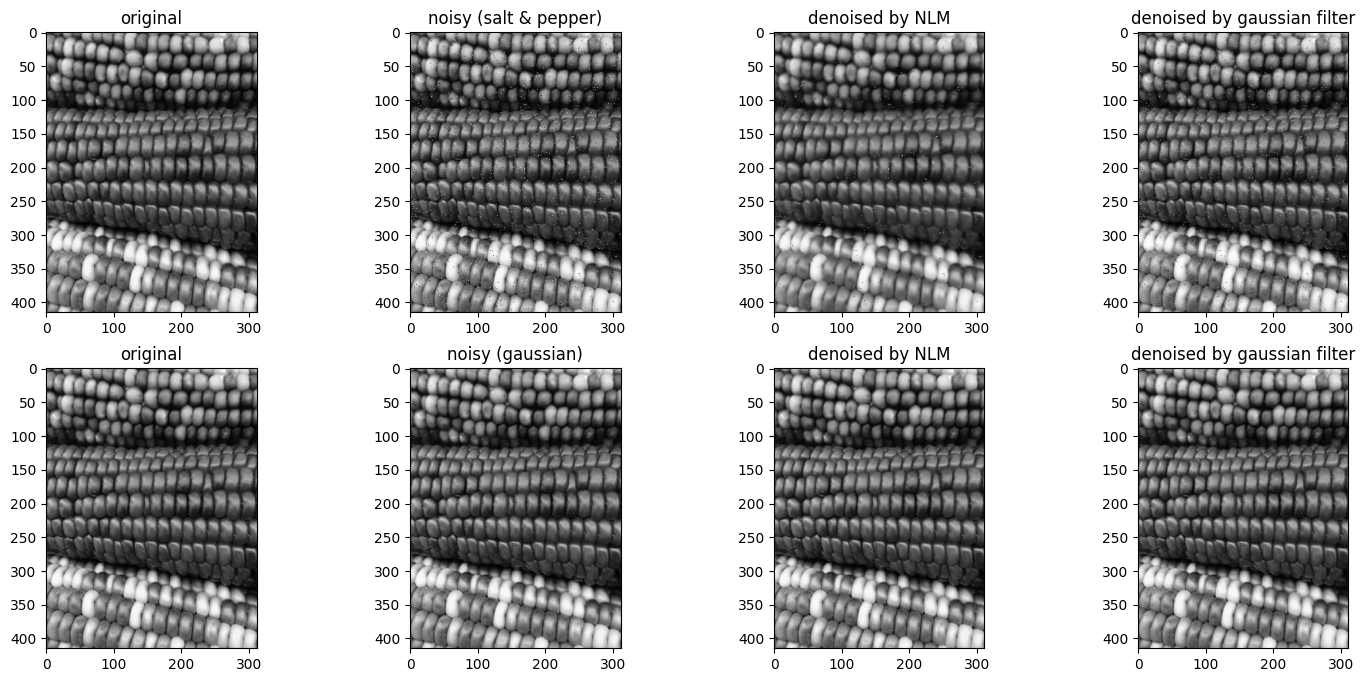

In [15]:
plt.figure(figsize=(18, 8))

plt.subplot(2, 4, 1)
plt.imshow(img2, 'gray')
plt.title('original')

plt.subplot(2, 4, 2)
plt.imshow(sp_noisy_img2, 'gray')
plt.title('noisy (salt & pepper)')

plt.subplot(2, 4, 3)
plt.imshow(nlm_sp_filtered_image2, 'gray')
plt.title('denoised by NLM')

plt.subplot(2, 4, 4)
plt.imshow(gaussian_sp_filtered_image2, 'gray')
plt.title('denoised by gaussian filter')

plt.subplot(2, 4, 5)
plt.imshow(img2, 'gray')
plt.title('original')

plt.subplot(2, 4, 6)
plt.imshow(gaussian_noisy_img2, 'gray')
plt.title('noisy (gaussian)')

plt.subplot(2, 4, 7)
plt.imshow(nlm_gaussian_filtered_image2, 'gray')
plt.title('denoised by NLM')

plt.subplot(2, 4, 8)
plt.imshow(gaussian_gaussian_filtered_image2, 'gray')
plt.title('denoised by gaussian filter')

plt.show()